# Plot 2D Histograms of Data

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import pandas as pd
import numpy as np

import os
from pathlib2 import Path

In [35]:
# Allow LaTeX labels

latex = False
try:
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    latex = True
except Exception:
    print("LaTeX not used.")

In [36]:
# Load data
qcd = pd.read_pickle('data/qcd_100000_pt_1000_1200.pkl')
h = pd.read_pickle('data/higgs_100000_pt_1000_1200.pkl')

In [37]:
# Save dir
save_dir = 'plots/histograms/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
dir_path = Path(save_dir)

In [38]:
# Apply cuts
pt_min = 1000
pt_max = 1200

print("Length Higgs: {}".format(len(h)))
qcd = qcd[(pt_min < qcd['pt']) & (qcd['pt'] < pt_max)]
h = h[(pt_min < h['pt']) & (h['pt'] < pt_max)]

print("Length Higgs after cut: {}".format(len(h)))

# Choose labels
x_axis = 'mass'
y_axis = 'd2'

qcd = qcd[[x_axis, y_axis]]
h = h[[x_axis, y_axis]]
h['tag'] = 'h'
qcd['tag'] = 'qcd'

main_df = pd.concat([qcd, h])

Length Higgs: 100000
Length Higgs after cut: 100000


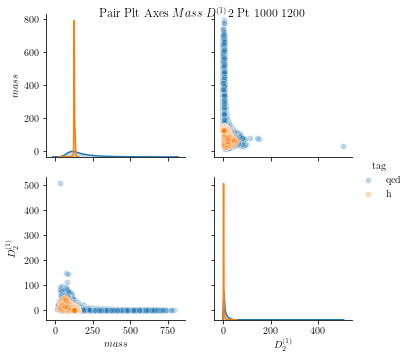

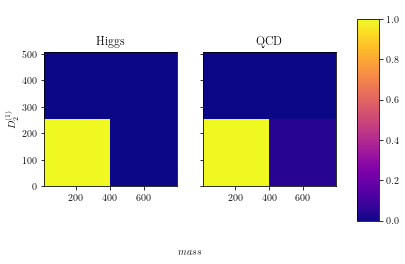

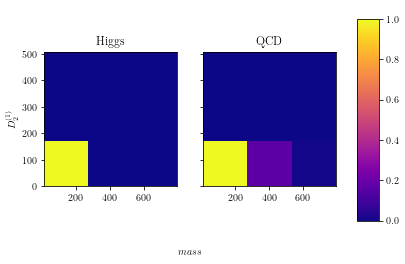

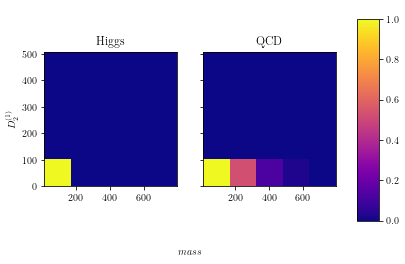

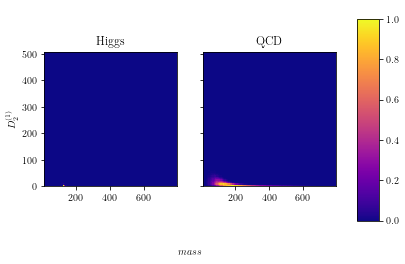

In [39]:
x_label = r'$mass$'
y_label = r'$D^{(1)}_2$'

pair_plt_name = 'pair_plt_axes_{}_{}_pt_{}_{}'.format(x_axis, y_axis, pt_min, pt_max)

pair_plt = sns.pairplot(main_df, hue="tag",
                       plot_kws = {'alpha': 0.3})

replacements = {x_axis : x_label, y_axis : y_label}
for i in range(2):
    for j in range(2):
        curr_x_l = pair_plt.axes[i][j].get_xlabel()
        curr_y_l = pair_plt.axes[i][j].get_ylabel()
        if not i == j:
            pair_plt.axes[i][j].set_alpha(0.5)
        if curr_x_l in replacements.keys():
            pair_plt.axes[i][j].set_xlabel(replacements[curr_x_l])
        if curr_y_l in replacements.keys():
            pair_plt.axes[i][j].set_ylabel(replacements[curr_y_l])


pair_plt_title = pair_plt_name
for k, v in replacements.items():
    pair_plt_title = pair_plt_title.replace(k, v)
pair_plt.fig.suptitle(pair_plt_title.replace("_", " ").title())
pair_plt.savefig(dir_path / Path(pair_plt_name))
plt.show()

n_bins = [2, 3, 5, 100]

min_x = main_df[x_axis].min()
max_x = main_df[x_axis].max()

min_y = main_df[y_axis].min()
max_y = main_df[y_axis].max()

for n_bin in n_bins:
    fig, axes = plt.subplots(nrows=1, ncols=2,
                           sharex=True, sharey=True)

    # Start Higgs Histogram
    fig_h = axes[0]
    
    (hist_h, hist_h_x, hist_h_y) = np.histogram2d(h[x_axis], h[y_axis], bins=n_bin, range=[[min_x, max_x], [min_y, max_y]])
    hist_h = np.transpose(np.divide(hist_h, np.max(hist_h))) # Norm to [0, 1] and transpose
    im = fig_h.imshow(
        hist_h, 
        cmap='plasma', 
        aspect=max_x/max_y, 
        origin='low', 
        extent=[hist_h_x[0], hist_h_x[-1], hist_h_y[0], hist_h_y[-1]]
    )
    fig_h.set_title('Higgs')
    # fig.colorbar(im, ax=fig_h)
    
    # Start QCD Histogram
    fig_qcd = axes[1]
    
    (hist_qcd, hist_qcd_x, hist_qcd_y) = np.histogram2d(qcd[x_axis], qcd[y_axis], bins=n_bin, range=[[min_x, max_x], [min_y, max_y]])
    hist_qcd = np.transpose(np.divide(hist_qcd, np.max(hist_qcd))) # Norm to [0, 1] and transpose
    
    im = fig_qcd.imshow(
        hist_qcd, 
        cmap='plasma', 
        aspect=max_x/max_y, 
        origin='low', 
        extent=[hist_qcd_x[0], hist_qcd_x[-1], hist_qcd_y[0], hist_qcd_y[-1]]
    )
    fig_qcd.set_title('QCD')
    # fig.colorbar(im, ax=fig_qcd)
    
    # Colorbar for both plots
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    
    fig.add_subplot(111, frameon=False)

    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel(replacements[x_axis])
    plt.ylabel(replacements[y_axis])
    plt.savefig(dir_path / 
                Path('histogram_axis_{}_{}_pt_{}_{}_bin_{}'.format(x_axis, y_axis, pt_min, pt_max, n_bin)))
    plt.show()
